In [1]:
%pip install pandas scikit-learn scipy

Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext memory_profiler

In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import pickle


In [3]:
def create_model(train_endog, train_exog, lag):
    model = VAR(train_endog, train_exog)
    var_results = model.fit(lag)

    def predict(prev_endog, future_exog, horizon):
        return var_results.forecast(y=prev_endog, steps=horizon, exog_future=future_exog)

    return predict, model.select_order, var_results

def standart_model(train_endog, train_exog, lag):
    with open('./model/std-scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)

    scaler = StandardScaler()
    train_endog_std = scaler.fit_transform(train_endog)

    model_predict, model_select_order, model = create_model(train_endog_std, train_exog, lag)

    def predict(prev_endog, future_exog, horizon):
        prev_endog_std = scaler.transform(prev_endog)
        predict_std = model_predict(prev_endog_std, future_exog, horizon)
        return scaler.inverse_transform(predict_std)

    return predict, model_select_order, model

def log_transformer():
    def apply(X):
        return np.log1p(X)
    
    def inverse(X):
        return np.expm1(X)

    return apply, inverse

def sqrt_transformer():
    def apply(X):
        return np.sqrt(X)
    
    def inverse(X):
        return X ** 2

    return apply, inverse

def fix_distribution_model(transformer, fix_indexes, train_endog, train_exog, lag):
    apply, inverse = transformer()

    def transform(fix_indexes, endog):
        for index in fix_indexes:
            endog[:, index] = apply(endog[:, index])

    transform(fix_indexes, train_endog)
    
    model_predict, model_select_order, model = standart_model(train_endog, train_exog, lag)

    def predict(prev_endog, future_exog, horizon):
        transform(fix_indexes, prev_endog)

        predictions = model_predict(prev_endog, future_exog, horizon)
        
        for index in fix_indexes:
            predictions[:, index] = inverse(predictions[:, index])
        
        return predictions

    return predict, model_select_order, model

In [4]:
data = pd.read_csv('./data/raw.csv', index_col=0)
data.head()

train_size = int(0.8 * len(data))
train, test = data[:train_size], data[train_size:]

In [ ]:
# model = VAR(endog=train[endog_cols], exog=train[exog_cols])
# lag_order_results = model.select_order(maxlags=15)

# optimal_lag = lag_order_results.bic

# print("Оптимальный порядок лага (BIC):", optimal_lag)

# var_results = model.fit(optimal_lag)
# print(var_results.summary())


In [5]:

def get_exog(time):    
    hour = time.hour
    sin_hour = math.sin(2 * np.pi * hour / 24)
    cos_hour = math.cos(2 * np.pi * hour / 24)
    weekday = time.weekday()
    sin_weekday = math.sin(2 * np.pi * weekday / 7)
    cos_weekday = math.cos(2 * np.pi * weekday / 7)
    return [sin_hour, cos_hour, sin_weekday, cos_weekday]

def get_future_exog(start_time, horizon):
    future_exog = []
    for i in range(0, horizon):
        delta = timedelta(minutes=15 * i)
        sin_hour, cos_hour, sin_weekday, cos_weekday = get_exog(start_time + delta)
        future_exog.append([sin_weekday, cos_weekday, sin_hour, cos_hour])
    return np.array(future_exog)


In [6]:
endog_cols = ['CarCount', 'BikeCount', 'BusCount']
exog_cols = [ "Hour_sin", "Hour_cos", "Day of the week_sin", "Day of the week_cos" ]

In [ ]:
def get_prev_endog(index, lag):
    return test[endog_cols].loc[(index - lag):index - 1].values

def get_time(index):
    day = test.loc[index]['Date']
    hour = test.loc[index]['Hour'] 
    minute = test.loc[index]['Minute']
    month = 9 if day < 20 else 8
    return datetime(2021, month, day, hour, minute)

def test_prediction(model_predict, lag, horizon, skip):
    all_results = []
    
    for index in range(test.index[lag], test.index[-1], horizon + skip):
        start_time = get_time(index)
        prev_endog = get_prev_endog(index, lag)
        future_exog = get_future_exog(start_time, horizon)
        predictions = model_predict(prev_endog, future_exog, horizon)

        indexes = np.arange(index, index + horizon).reshape(-1, 1)
        window_data = np.hstack([indexes, predictions])

        if skip > 0:
            skip_block = np.full((skip, window_data.shape[1]), np.nan)
            window_data = np.vstack([window_data, skip_block])
        
        all_results.append(window_data)
    
    if all_results:
        return np.vstack(all_results)
    return np.empty((0, 3))


In [ ]:

optimal_lag = 29

model_predict, model_selectorder, model = standart_model(train[endog_cols].values, train[exog_cols], optimal_lag)


#model_predict, model_selectorder, model = create_model(train[endog_cols].values, train[exog_cols], optimal_lag)
#model_predict, model_selectorder, model = fix_distribution_model(sqrt_transformer, [1, 2], train[endog_cols].values, train[exog_cols], optimal_lag)
#model_predict, model_selectorder, model = fix_distribution_model(log_transformer, [1, 2], train[endog_cols].values, train[exog_cols], optimal_lag)


#lag_order_results = model_selectorder(maxlags=30)
#lag_order_results.summary()

# model_summary()

# standart - AIC 29, BIC 5, FPE 29, HQIC 29
# sqrt - AIC 29, BIC 4, FPE 29, HQIC 29
# standart weekday_sin_cos AIC 29, BIC 4, FPE 29, HQIC 29


28.7 ms ± 2.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [95]:
model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 03, Apr, 2025
Time:                     23:51:29
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -3.16714
Nobs:                     4732.00    HQIC:                  -3.41158
Log likelihood:          -11482.0    FPE:                  0.0288966
AIC:                     -3.54405    Det(Omega_mle):       0.0272746
--------------------------------------------------------------------
Results for equation y1
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.000032         0.007364           -0.004           0.997
Hour_sin                   -0.206375         0.019748          -10.451           0.000
Hour_cos                   -0.223132   

In [ ]:

horizon = 8
skip = 1

pred_data = test_prediction(model_predict, optimal_lag, horizon, skip)

832 μs ± 5.66 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


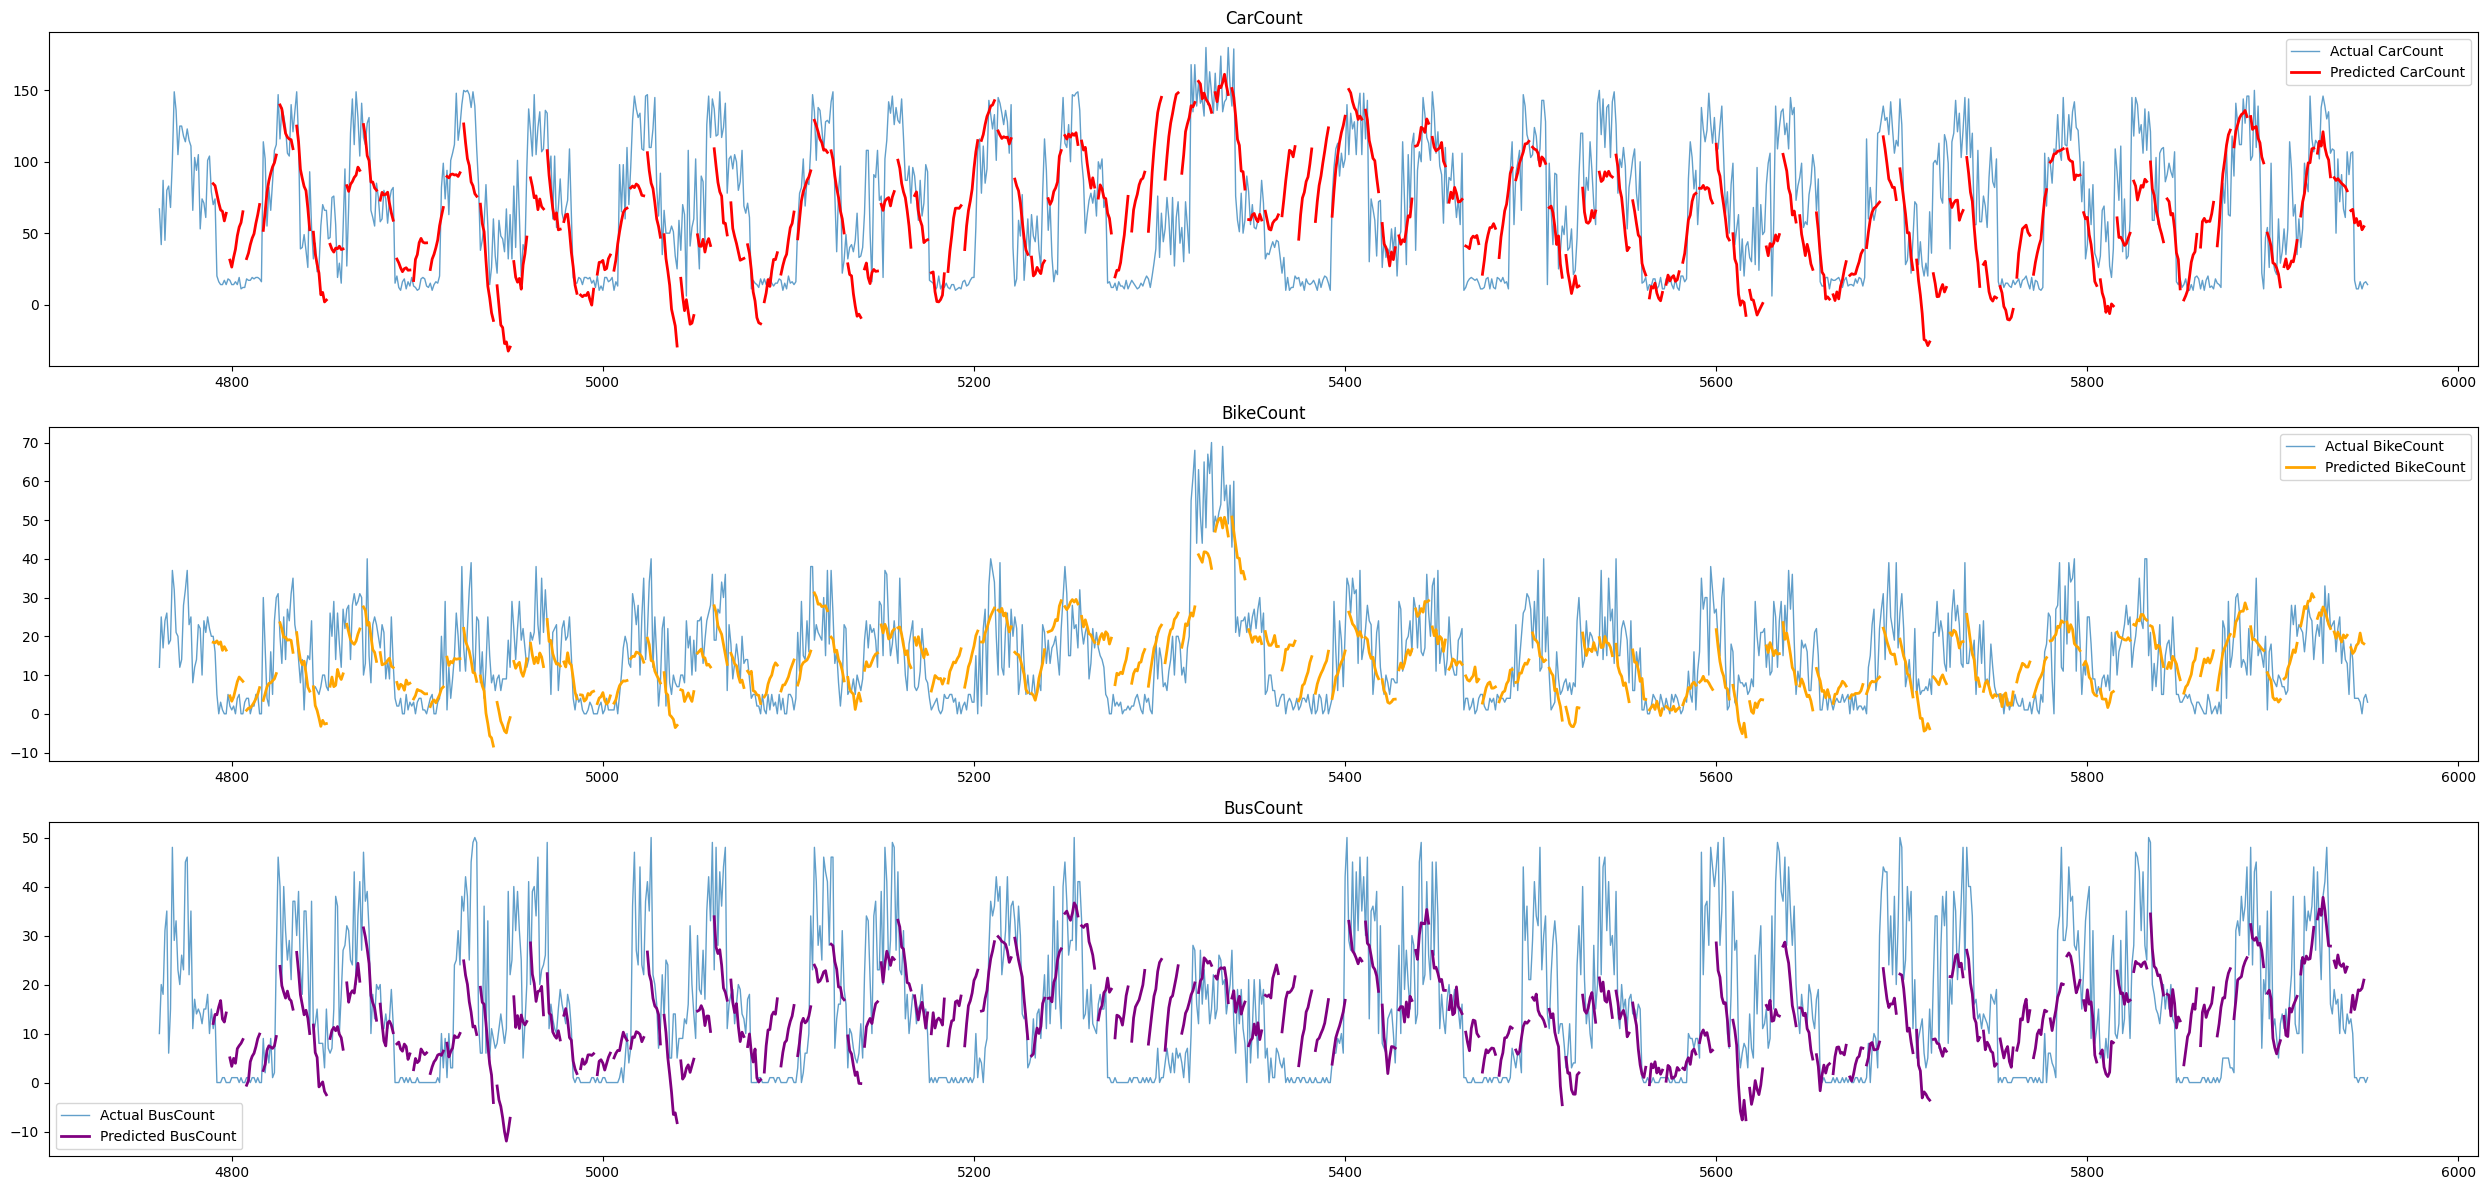

In [97]:
y_orig = test[['CarCount', 'BikeCount', 'BusCount']]
time = test.index

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 12))

def show_prediction(ax, time, data, col, color, pred_x, pred_y):
        ax.plot(time, data[col], 
                linewidth=1,
                alpha=0.7,
                label=f'Actual {col}')
        ax.plot(pred_x, pred_y, 
                linewidth=2,
                color=color,
                label=f'Predicted {col}')
        ax.set_title(col)
        ax.legend()

show_prediction(ax1, time, y_orig, 'CarCount', 'r', pred_data[:, 0], pred_data[:, 1])
show_prediction(ax2, time, y_orig, 'BikeCount', 'orange', pred_data[:, 0],  pred_data[:, 2])
show_prediction(ax3, time, y_orig, 'BusCount',  'purple', pred_data[:, 0], pred_data[:, 3])

plt.tight_layout()
plt.show()


In [98]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

metrics = {
    'SMAPE': lambda y_true, y_pred: 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e+07)),
    'MAE': mean_absolute_error,
    'RMSE': root_mean_squared_error,
    'MAD': lambda y_true, y_pred: np.median(np.abs(y_true - y_pred))
}

In [99]:
y_pred = []

y_test_start = test.index[optimal_lag]
y_test_end = test.index[-1]
horizon = 8

for index in range(y_test_start, y_test_end + 1, horizon):
    start_time = get_time(index)
    prev_endog = get_prev_endog(index, optimal_lag)
    future_exog = get_future_exog(start_time, horizon)
    predictions = model_predict(prev_endog, future_exog, horizon)
    y_pred.append(predictions)

y_pred = np.array(y_pred)

In [100]:
from numpy.lib.stride_tricks import sliding_window_view
y_orig_horizon = np.squeeze(sliding_window_view(test[endog_cols].loc[y_test_start: y_test_end].values, window_shape=(horizon, len(endog_cols))), 1)

horizon_metrics = { metric: { endog: [] for endog in endog_cols } for metric in metrics.keys() }

for orig, pred in zip(y_orig_horizon, y_pred):
    for metric in horizon_metrics.keys():
        for index, feature in zip(range(0, len(endog_cols)), endog_cols):
            horizon_metrics[metric][feature].append(metrics[metric](orig[:, index], pred[:, index]))


for metric in horizon_metrics.keys():
    for feature in horizon_metrics[metric].keys():
        horizon_metrics[metric][feature] = np.mean(horizon_metrics[metric][feature])

In [101]:
horizon_metrics

{'SMAPE': {'CarCount': 0.0009378221845294672,
  'BikeCount': 0.00019160220535206158,
  'BusCount': 0.0002455614131544932},
 'MAE': {'CarCount': 46.89175718184451,
  'BikeCount': 9.580139240715441,
  'BusCount': 12.27811453799379},
 'RMSE': {'CarCount': 51.55899248840752,
  'BikeCount': 10.98254524136409,
  'BusCount': 13.685475195623813},
 'MAD': {'CarCount': 47.018835561254754,
  'BikeCount': 9.128591808533635,
  'BusCount': 12.272013759260043}}

In [102]:
import pickle

with open('./model/var.pkl', 'wb') as file:
    pickle.dump(model, file)

Лучший результаты: 
- VAR lag 5 (1)
- LSTM643232 10 - over
- LSTM1286464 10 - over
- VAR lag 10 - over
- LSTM643232 5 (3)
- LSTM3216 4 (2)